# California Opioid Epidemic Prediction
The Data set is from a [KAGGLE competition](https://www.kaggle.com/apryor6/us-opiate-prescriptions)

### Import and Process Data

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

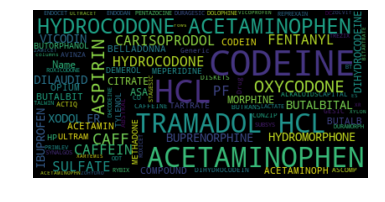

In [2]:
opioids = pd.read_csv('data/opioids.csv')
wordcloud = WordCloud(max_font_size=42).generate(str(opioids))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [3]:
prescribers = pd.read_csv('data/prescriber-info.csv')
prescribers = prescribers.dropna()
overdoses = pd.read_csv('data/overdoses.csv', thousands = ',')
overdoses = overdoses.dropna()

In [4]:
prescribers.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,43,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [5]:
df_prescribers_col = pd.Series(prescribers.columns)
df_prescribers_col

0                                 NPI
1                              Gender
2                               State
3                         Credentials
4                           Specialty
5                             ABILIFY
6               ACETAMINOPHEN.CODEINE
7                           ACYCLOVIR
8                       ADVAIR.DISKUS
9                            AGGRENOX
10                 ALENDRONATE.SODIUM
11                        ALLOPURINOL
12                         ALPRAZOLAM
13                     AMIODARONE.HCL
14                  AMITRIPTYLINE.HCL
15                AMLODIPINE.BESYLATE
16     AMLODIPINE.BESYLATE.BENAZEPRIL
17                        AMOXICILLIN
18      AMOX.TR.POTASSIUM.CLAVULANATE
19             AMPHETAMINE.SALT.COMBO
20                           ATENOLOL
21               ATORVASTATIN.CALCIUM
22                            AVODART
23                       AZITHROMYCIN
24                           BACLOFEN
25           BD.ULTRA.FINE.PEN.NEEDLE
26          

In [6]:
prescribers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24237 entries, 0 to 24999
Columns: 256 entries, NPI to Opioid.Prescriber
dtypes: int64(252), object(4)
memory usage: 47.5+ MB


In [7]:
prescribers.describe()

,NPI,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
count,2.423700e+04,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,...,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000,24237.000000
mean,1.498151e+09,3.190329,2.414655,1.068202,7.113958,0.719974,9.032471,9.415109,16.360358,2.411726,...,2.217024,2.267772,2.560672,0.819697,19.404629,3.393861,4.118208,1.138260,11.721541,0.589223
std,2.878020e+08,20.920849,11.777393,6.729293,26.079657,5.282100,36.804320,29.511625,70.143701,14.227994,...,10.165795,13.369204,23.545497,4.997169,87.267206,17.121904,18.564032,10.422051,39.481755,0.491985
min,1.003002e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.245484e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.497842e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.740405e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.992999e+09,770.000000,644.000000,356.000000,1105.000000,275.000000,2431.000000,790.000000,5716.000000,596.000000,...,528.000000,902.000000,1814.000000,143.000000,6029.000000,596.000000,772.000000,694.000000,2107.000000,1.000000


In [8]:
prescribers.shape

(24237, 256)

In [9]:
overdoses.head()

,State,Population,Deaths,Abbrev
0,Alabama,4833722,723,AL
1,Alaska,735132,124,AK
2,Arizona,6626624,1211,AZ
3,Arkansas,2959373,356,AR
4,California,38332521,4521,CA


In [10]:
df_overdoses_col = pd.Series(overdoses.columns)
df_overdoses_col

0         State
1    Population
2        Deaths
3        Abbrev
dtype: object

In [11]:
overdoses.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 4 columns):
State         50 non-null object
Population    50 non-null int64
Deaths        50 non-null int64
Abbrev        50 non-null object
dtypes: int64(2), object(2)
memory usage: 2.0+ KB


In [12]:
overdoses.describe()

,Population,Deaths
count,5.000000e+01,50.000000
mean,6.309648e+06,939.180000
std,7.061295e+06,898.195486
min,5.826580e+05,43.000000
25%,1.857857e+06,281.000000
50%,4.510382e+06,712.000000
75%,6.901760e+06,1209.750000
max,3.833252e+07,4521.000000


In [13]:
overdoses.shape

(50, 4)

In [14]:
opioids = opioids 
name = opioids['Drug Name']
import re
new_name = name.apply(lambda x:re.sub("\ |-",".",str(x)))
columns = prescribers.columns
abandoned_variables = set(columns).intersection(set(new_name))
kept_variable=[]
for each in columns:
    if each in abandoned_variables:
        pass
    else:
        kept_variable.append(each)

In [15]:
df = prescribers[kept_variable]
df.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


In [16]:
cols = ['Specialty']
dummies = pd.concat([pd.get_dummies(df[cols][col], drop_first = True, prefix= col) for col in df[cols]], axis=1)
dummies.head()

,Specialty_Allergy/Immunology,Specialty_Anesthesiology,Specialty_Behavioral Analyst,Specialty_CRNA,Specialty_Cardiac Electrophysiology,Specialty_Cardiac Surgery,Specialty_Cardiology,Specialty_Certified Clinical Nurse Specialist,Specialty_Certified Nurse Midwife,Specialty_Chiropractic,...,Specialty_Sports Medicine,Specialty_Student in an Organized Health Care Education/Training Program,Specialty_Surgery,Specialty_Surgical Oncology,Specialty_Thoracic Surgery,Specialty_Thoracic Surgery (Cardiothoracic Vascular Surgery),Specialty_Unknown Physician Specialty Code,Specialty_Unknown Supplier/Provider,Specialty_Urology,Specialty_Vascular Surgery
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### GridSearched RandomForest Predictions

In [17]:
n_estimators = list(range(20,220,10))
max_depth = list(range(2, 22, 2)) + [None]

target = 'Opioid.Prescriber'

X = dummies
y = df['Opioid.Prescriber']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) 
clf_params = {'n_estimators':n_estimators,'max_depth':max_depth}   
clf_gs = GridSearchCV(RandomForestClassifier(), clf_params, cv=5, verbose=1, n_jobs=-1)
clf_gs.fit(X_train,y_train) 


print(clf_gs.best_params_)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 1100 out of 1100 | elapsed: 14.1min finished


{'max_depth': None, 'n_estimators': 40}


In [18]:
max_depth_best = clf_gs.best_params_['max_depth']      
n_estimators_best = clf_gs.best_params_['n_estimators']  

print("The Best Max Depth is: ", max_depth_best)
print("The Best n_estimator is: ", n_estimators_best)

The Best Max Depth is:  None
The Best n_estimator is:  40


In [19]:
clf_gs = RandomForestClassifier(max_depth=max_depth_best,n_estimators=n_estimators_best) 
clf_gs.fit(X_train,y_train)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [20]:
clf_rf_score = clf_gs.score(X_test,y_test)
print('The GridSearched RandomForest score is: ',clf_rf_score)

The GridSearched RandomForest score is:  0.756188118812


In [21]:
clf_preds = clf_gs.predict(X_test)
print('The GridSearched RandomForest Prediction is: ', clf_preds)

The GridSearched RandomForest Prediction is:  [0 1 1 ..., 1 0 1]


In [22]:
print("Confusion Matrix:\n")
print(pd.crosstab(pd.concat([X_test,y_test],axis=1)[target], clf_preds, rownames=['Actual Values'], colnames=['Predicted Values']))

Confusion Matrix:

Predicted Values     0     1
Actual Values               
0                 1212   761
1                  421  2454


In [23]:
feature_importances = pd.Series(clf_gs.feature_importances_, index=X.columns).sort_values().tail(42)
print("Feature Importances:\n")
feature_importances

Feature Importances:



Specialty_Thoracic Surgery                                                  0.002684
Specialty_Neurology                                                         0.002759
Specialty_Specialist                                                        0.003040
Specialty_Hand Surgery                                                      0.003055
Specialty_Geriatric Medicine                                                0.003087
Specialty_Infectious Disease                                                0.003163
Specialty_Registered Nurse                                                  0.003246
Specialty_General Practice                                                  0.003259
Specialty_Interventional Pain Management                                    0.003307
Specialty_Plastic and Reconstructive Surgery                                0.003327
Specialty_Pain Management                                                   0.003730
Specialty_Neurosurgery                                           

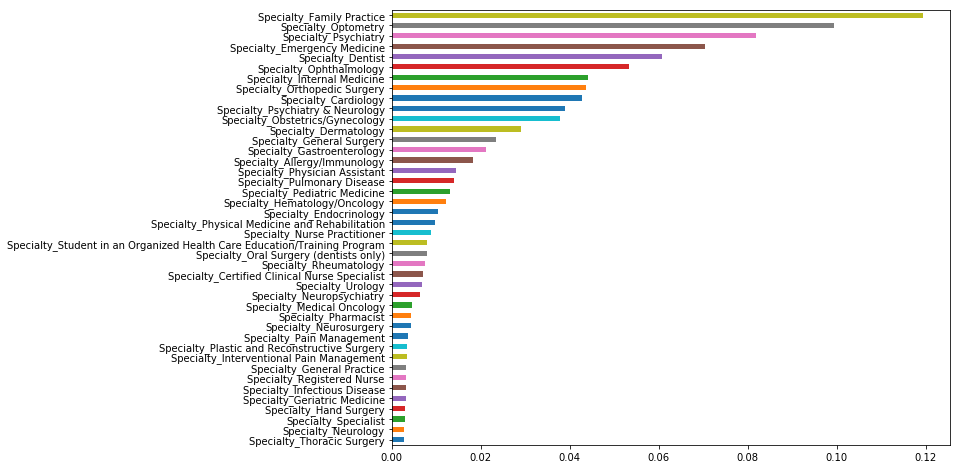

In [24]:
feature_importances.plot(kind="barh", figsize=(10,8))
plt.show()

In [25]:
def cv_score(X,y,cv,n_estimators,max_depth):
    rf = RandomForestClassifier(n_estimators=n_estimators_best,
                                max_depth=max_depth_best)
    s = cross_val_score(rf, X, y, cv=cv, n_jobs=-1)
    return("{} Score is :{:0.3} ± {:0.3}".format("Random Forest", s.mean().round(3), s.std().round(3)))

In [26]:
dict_best = {'max_depth': None, 'n_estimators': 20}
n_estimators_best = dict_best['n_estimators']
max_depth_best = dict_best['max_depth']
cv_score(X,y,5,n_estimators_best,max_depth_best)

'Random Forest Score is :0.76 ± 0.005'

### California Prescribed Opioids

In [27]:
Opioid_prescibers = prescribers.loc[prescribers['Opioid.Prescriber'] == 1]
CA_Opioid_prescibers = Opioid_prescibers.loc[Opioid_prescibers['State'] == 'CA']
CA_Opioid_prescibers.head()

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACETAMINOPHEN.CODEINE,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
64,1902916729,M,CA,M.D.,Internal Medicine,0,0,0,0,0,...,0,12,0,0,0,0,0,0,0,1
71,1174601066,M,CA,MD,Internal Medicine,0,45,23,0,0,...,26,0,0,0,46,0,26,0,18,1
99,1285792762,M,CA,M.D.,General Practice,0,0,0,63,0,...,11,0,0,0,60,86,0,17,68,1
105,1063590743,M,CA,MD,Internal Medicine,0,41,14,19,0,...,0,0,0,0,48,0,28,0,90,1
130,1356448336,M,CA,MD,Internal Medicine,0,19,19,0,0,...,0,0,0,0,0,0,0,0,0,1


Total amount of CA Doctors Prescribing Opioids is:  1427


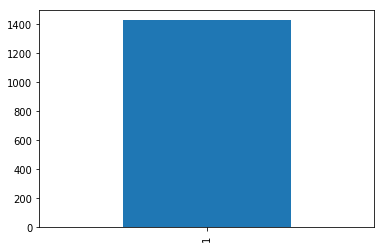

In [28]:
Total_CA_Opioid_prescibers = len(CA_Opioid_prescibers)
print('Total amount of CA Doctors Prescribing Opioids is: ', Total_CA_Opioid_prescibers)
pd.value_counts(CA_Opioid_prescibers['Opioid.Prescriber']).plot.bar()
plt.show()

In [29]:
overdoses['DeathPercentile'] = overdoses.Deaths/overdoses.Population
CA_overdoses = overdoses.loc[overdoses['State'] == 'California']
CA_overdoses

,State,Population,Deaths,Abbrev,DeathPercentile
4,California,38332521,4521,CA,0.000118


In [30]:
CAOD = CA_overdoses['Deaths'].values
print("The Number of OD Death's in Californias is: ",int(CAOD))

The Number of OD Death's in Californias is:  4521


In [31]:
cols_to_drop  = ['Specialty','NPI','Gender','Credentials']
df = df.drop(cols_to_drop,axis=1)
cols = ['Opioid.Prescriber','State']
aux = df.drop(cols,axis=1)
all_ops = aux[aux.columns.tolist()].sum(axis=1)
df1 = df[['State','Opioid.Prescriber']]
df2=  pd.concat([all_ops, df1],  axis  =  1)
df2 = df2.rename(columns={0: 'total_opioids'})
CA_total_prescribed = df2['State'].value_counts().head(1)
print("The Total Amount of Opioids Prescribed in", CA_total_prescribed)


The Total Amount of Opioids Prescribed in CA    2487
Name: State, dtype: int64


In [32]:
Avg_CAOD_per_prescription = CAOD / CA_total_prescribed

In [33]:
print("The Average OD Death's per Prescriptions in ", Avg_CAOD_per_prescription)

The Average OD Death's per Prescriptions in  CA    1.817853
Name: State, dtype: float64
